# (G10) Transformer로 번역기 만들기

- 나름대로 혁신적이었던 Seq2seq 구조로 번역기를 만들었으나 성능이 기대에 미치지 않아 실망한 사람들도 있을 것이다. 하지만 Transformer는 다르다.


- Trasformer는 현재까지도 각종 번역 부문에서 최고의 성능을 자랑하는 모델이니 이번에는 정말 멋진 번역기를 만들 수 있을 것이다. 이전 강의 노드에서 배웠던 개념들이 어떻게 구현되는지 보자.


- Trasformer 모델은 앞으로 자연어처리 분야에서는 항상 빠지지 않는 중요한 모델 구조의 근간이 되기 때문에 오늘 구현 실습을 통해 트랜스포머의 구조를 꼼꼼히 파악하자.


## 준비물

- 터미널을 열고 프로젝트를 위한 디렉토리를 생성하자.
```c
$ mkdir -p ~/aiffel/transformer
```


- 실습에서는 한국어가 포함된 말뭉치를 사용하므로, 한국어를 잘 시각화하기 위한 준비가 필요하다. 다만 ```matplotlib``` 라이브러리의 기본 폰트는 한국어를 지원하지 않기에 Attention Map을 확인하기 위해 한국어를 지원하는 폰트로 변경해 주도록 한다. 아직 컴퓨터에 글꼴이 설치되어 있지 않다면, 터미널에서 나눔 글꼴을 설치한다.
```c
$ sudo apt -qq -y install fonts-nanum
```


- 아래 코드는 앞으로 필요한 경우 한글을 실행해야 할 때 미리 한 번씩 실행해주면 된다.

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

print("done")

done


****
# 내부 모듈 구현하기 

- 이번 코스는 Transformer를 완성하는 데에 필요한 모듈들을 하나하나 만든 후, 조립하며 완성하는 방식으로 진행할 것이다.


- tensor로 변환한 입력 데이터가 주어졌다고 가정하고 흐름을 생각해보자.
- 최조의 텍스트 입력 데이터는 ```[batch_size x length]```의 형태를 가지고 있을 것이다.
- 번역이 끝나고 난 최종 출력 데이터는 ```[batch_size x length x vocab_size]```의 형태를 가지게 된닫.
- 번역 문제는 매 스텝마다 ```vocab_size```만큼의 클래스 개수 중에 적당한 단어를 선택하는 작업을 ```length```만큼 반복하는 것이다.
- 모델 구성하는 과정에서 레이러를 통과할 때 마다 텐서의 shape가 어떻게 바뀌는지 살펴보자.

> 1. 입력 데이터 --> ```[batch_size x length]```    
> 2. Sourde & Target Embedding --> ```[batch_size x length x d_emb]```    
> 3. **Positional Encoding** --> 2번의 결과에 더해지므로 shape 변화 없음.    
> 4. **Multi-Head Attention**는 아래와 같이 여러 개의 서브 모듈들이 존재한다.
 >> (1) **Split Heads** --> ```[batch_size x length x heads x (d_emb / n_heads)]```    
 >> (2) **Masking for Masked Attention**    
 >> (3) **Scaled Dot Prodect Attention**    
 >> (4) **Combine Heads** --> ```[batch_size x length x d_emb]```    
> 5. Resudual Connection     
> 6. Layer Normalization     
> 7. **Position-wise Feed-Forward Network** --> ```[batch_size x length x d_ff]```
> 8.  Output Linear Layer --> ```[batch_size x length x vocab_size]```


- 굵게 표시된 모듈을 제외하면 나머지는 텐서플로우 내부에 이미 구현체가 포함되어 있어서 간단하게 사용할 수 있다. 


##  Posotional Encoding

![](https://user-images.githubusercontent.com/67767735/116876063-d4114a80-ac56-11eb-8797-1ae93c9384f5.png)
- 우선 Positional Encoding부터 살펴보자.
- 먼저 프로젝트에 사용할 라이브러리를 ```import```해오자.

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

print(tf.__version__)

2.4.1


In [4]:
# Posotional Encoding
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

print("done")

done


- 위 소스는 가급적이면 그대로 사용하는 것이 좋다.

## Multi-Head Attention

![](https://user-images.githubusercontent.com/67767735/116876171-fe630800-ac56-11eb-839c-7311ab3ec00b.png)
- Multi-Head Attention은 여러 개의 서브 모듈을 결합하여 완성한다.
- Embedding된 입력을 **Head 수로 분할**하는 ```split-heads()```, 분할된 입력으로부터 **Attention 값을 구하는** ```scaled_dot_product_attention()```, 연산이 종료되고 **분할된 Head를 다시 하나로 결합**시켜주는 ```combine_heads()```까지 ```MultiHeadAttention``` 클래스를 정의하여 모두 포함시켜주자.


- 뭔가 빠진 것이 있다면 바로 Masking 부분인데, **마스크의 형태를 결정하는 것은 모델 외부의 훈련 데이터**이기 때문에 Masking을 생성하는 함수는 ```MultiHeadAttention``` 외부에 정의되는 것이 올바르다.    
- 마스크를 생성하는 함수는 모델을 완성한 후에 구현하도록 하겠으나, 생성된 마스크를 처리할 수 있도록 ```scaled_dot_product_attention()```에는 아래 한 줄을 포함하자.
```c
# scaled_qk: Attention을 위한 Softmax 직전의 Scaled QK
if mask is not None: scaled_qk += (mask * -1e9)
```


- 아래 소스의 빈칸을 채워 ```MultiHeadAttention``` 클래스를 완성해보자.

In [19]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        
        # 내 코드: scaled_qk = tf.tensordot(Q, tf.transpose(K), axes=1) / tf.sqrt(d_k)
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)
        
        if mask is not None: scaled_qk += (mask * -1e9) 

        # 1. Attention Weights 값 구하기 -> attentions
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        
        # 2. Attention 값을 V에 곱하기 -> out 
        # 내 코드: out = tf.tensordot(attention, V, axes=1)
        out = tf.matmul(attentions, V)
        
        return out, attentions
        

    def split_heads(self, x):
        """
         Embedding을 Head의 수로 분할하는 함수
         x: [ batch x length x emb ]
         return: [ batch x length x heads x self.depth ]
        
        """
        bsz = x.shape[0] # x의 1차원 값 
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm = [0, 2, 1, 3])
        
        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수
        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        
        """
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm = [0, 2, 1, 3])
        combine_x = tf.reshape(combine_x, (bsz, -1, self.d_model))
        
        return combined_x
    

    def call(self, Q, K, V, mask):
     
        """
        아래 순서에 따라 소스를 작성하세요.
        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out
        
        """
        
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
                                                                   WQ_splits, 
                                                                   WK_splits, 
                                                                   WV_splits, 
                                                                   mask
                                                                   )
        
        out = self.combine_heads(out)
        out = self.linear(out)
        
        return out, attention_weights

print("done")

done


- 쉽진 않은 작업니다. 필자는는 Multi-Head Attention을 처음 구현할 적에 Head를 나눈다는 개념이 너무 헷갈려서 반복문을 돌며 ```[idx : idx + self.depth]```로 인덱싱해서 처리를 했던 기억이 있다.
- 이렇게 하면 연산하는 데 정말 많은 시간이 걸리니 부디 독자들은 이런 시행착오를 겪지 않았으면 좋겠다.

## Position-wise Feed-Forward Network

![](https://user-images.githubusercontent.com/67767735/116876328-4124e000-ac57-11eb-8599-5530ee517a19.png)
- 논문에서도 설명이 간략했으며 구현도 아주 쉬운 편이다.

In [ ]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

print("done")

- ```d_ff```는 논문의 설명대로라면 ```2048```일 것이고, ```d_model```은 ```512```일 것이다. ```[batch x length x d_model]```의 입력을 받아 ```w_1```이 **2048차원으로 매핑**하고 활성함수 **ReLU**를 적용한 후, 다시 ```w_2```를 통해 **512차원으로 되돌리는 과정**까지의 **FFN**을 살펴보았다.  

****
# 모듈 조립하기 

- 여기까지 내부에 포함될 모듈등을 모두 완성해보았다. 이 모든 모듈들을 가지고 트랜스포머를 완성할 수 있는데, 정확하게는 **트랜스포머의 Encoder 한 층**과 **Decoder 한 층을 각각 완성**할 수 있는 것이다.


- 논문에는 Encoder와 Decoder가 각각 6번씩 쓰였으니 위 코드를 5번 더 짜야 논문 속 트랜스포머를 구현할 수 있는 것이 아니냐고 물을 수 있다. 하지만 우린 더 효율적인 방법으로 트랜스포머를 완성할 것이니 걱정은 내려놓는 것이 좋다.


- [Attention is All you Need](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)의 9 페이지를 보면 표가 하나 있는데, 이는 **트랜스포머가 얼마나 많은 실험을 통해서 탄생한 모델**인지를 보여준다.
- 이런 실험을 가능하게 하려면 **모델이 동적으로 완성될 수 있게끔** 해야 한다. 즉, 레이어 수를 원하는 만큼 쌍아 실험을 자유자재로 할 수 있게 모델을 완성하자는 것이다.


- 방법은 단순하다. 마치 텐서플로우읜 ```Dense``` 레이어를 사용하듯이 ```EncoderLayer```, ```DecoderLayer```를 쓸 수 있게 ```tf.keras.layers.Layer``` **클래스를 상속받아 레이어 클래스로 정의**해주면 된다. 우리는 이미 ```Layer``` 클래스를 정의해본 적이 있는데, 바로 직전의 ```MultiHeadAttention```이 그렇렇게 정의된 레이어이다. 이 반법을 사용하면 아래와 같은 용법으로 트랜스포머 레이어를 사용할 수 있다.
```c
N = 10
# 10개의 Linear Layer를 한 방에!
linear_layers = [tf.keras.layers.Dense(30) for _ in range(N)]
# 10개의 Encoder Layer도 한 방에!
enc_layers = [TransformerEncoderLayer(30) for _ in range(N)]
```


- 혹시라도 이런 동적 방식이 낯설다면 지금부터라도 익숙해지는 것이 좋다.


## Encoder 레이어 구현하기 

In [21]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

print("done")

done


- 트랜스포머의 구현은 정말 많은데, 그중에서 **Normalization Layer의 위치**에 대한 논의가 종종 나온다. 실제 논문에서는 *[Input] - [Module] - [Residual] - [Norm](Module=MHA, FFN)*으로 표현되어 있지만 정작 Official 구현인 구글의 Tensor2Tensor에서는 *[Input] - [Norm] - [Module] - [Residual] 방식을 사용했다.


- 강의 작성자는 자신의 경험에 따라 레이어가 많아질수록 후자가 약간 더 좋은 성능을 보였기에 논문 대신 Official 구현을 따르길 권장한다. 이번 프로젝트는 소규모라서 큰 차이가 나지 않으니 알아두기만 해도 괜찮을 것이다.


- 참고로 트랜스포머의 Layer Normalization의 위치에 대한 논의를 다룬 [On Layer Normalization in the Transformer Architecture](https://arxiv.org/pdf/2002.04745.pdf)이라는 제목의 논문이 2020년 초반에 발표되었다. 이 논문에서는 모듈 앞에 Normalization Layer를 두는 pre-LN 방식이 왜 유리한지 설명하고 있다.


## Decoder 레이어 구현하기

- 위 ```EncoderLayer``` 클래스를 참고하여 ```DecoderLayer``` 클래스를 완성하자.
- 참고로 Decoder에서는 두 번의 Attention이 진행되니 반환되는 Attention도 2개이다.

In [22]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, n_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, n_heads)
        
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out = self.do(out)
        out += residual
        
        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_2(x)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out = self.do(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, dec_attn, dec_enc_attn

print("done")

done


- ```EncoderLayer```와 ```DecoderLayer```를 모두 정의했으니 이를 조립하는 것은 어렵지 않을 것이다. 이를 이용해 ```Encoder```와 ```Decoder``` 클래스를 정의해보자.

In [23]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

print("done")

done


In [24]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

print("done")

done


## Transformer 완성하기

- 정의된 ```Encoder```와 ```Decoder```를 가지고 최종적으로 트랜스포머를 완성해보자.
- 아래 조건을 만족하며 소스 빈칸을 채워 ```Transformer``` 클래스를 완성하자.

> <조건>
> 1. ```shared``` 변수를 매개변수로 받아 ```True```일 경우 **Decoder Embedding과 출력층 Linear의 Weight를 공유**할 수 있게 하라. Weight가 공유될 경우 Embedding 값에 **sqrt(d_model)**을 곱해줘야 하는 것도 잊으면 안된다. (참고: ```tf.keras.layers.Layer.set_weights()```)
> 2. 우리가 정의한 ```positioanl_encoding```의 반환값 형태는 ```[length x d_model]```인데, 이를 더해 줄 Embedding 값 형태가 ```[batch x length x d_model]```이라서 연산이 불가능하다. **연산이 가능하도록 수정**하자. (참고: ```tf.expand_dims()```, ```np.newaxis```)

In [26]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len,
                 dropout=0.2,
                 shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        # 1. Embedding Layer 정의
        self.enc_emb = tf.kers.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.kers.layers.Embedding(src_vocab_size, d_model)
        
        # 2. Positional Encoding 정의, Dropout 정의
        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)
        
        # 3. Encoder / Decoder 정의
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)
        
        # 4. Output Linear 정의
        self.fc = tf.keras.layers.Dense(tgt_vocab_size)
        
        # 5. Shared Weights
        self.shared = shared
        
        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights)) 
       
    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)
        
        if self.shared: out *= tf.math.sqrt(self.d_model)
        
        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)
        
        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embeddong(self.dec_emb, dec_in)
        
        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

print("done")

done


****
# 모델 밖의 조력자들

- **Masking**을 살펴보자.
- 그리고 트랜스포머의 **Learning Rate**가 일반적이지 않다는 것도 기억하고 있을 것이다.
- 지금부터는 **모델 외적인 부분을 정의**해 주도록 하겠다.
- 이번 스텝에서는 데이터의 특성이나 학습 과정에 따라 달라지는 부분을 다루게 된다.


- 먼저 Masking은 이전 노드에서 배운 ```generate_causality_mask()```에 약간의 소스 코드만 추가해서 사용하면 된다.

In [27]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

print("done")

done


- ```generate_padding_mask()```는 Attention을 할 때에 ```<PAD>``` 토큰에도 Attention을 주는 것을 방지해주는 역할을 한다. 
- 일전에 Seq2Seq 모델에서 Loss에 대한 Masking을 해줄 때도 위와 같은 방법으로 진행했었다.
- 한 배치 데이터에서 ```<PAD>``` 토큰으로 이뤄진 부분을 모두 찾아내는 마스크를 생성하자.

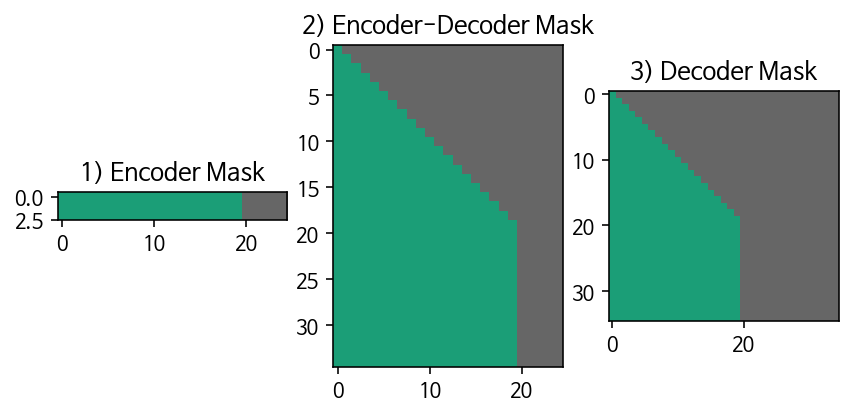

In [28]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

- 첫번째 마스크는 각 배치 별로 **데이터의 꼬리 부분을 Masking**하는 형태임을 알 수 있다. 
- 두번째와 세번째에 있는 Decoder가 연관된 마스크는 낯설어보일 수 있다. 이것이 바로 **Causality Mask와 padding Mask를 결합한 형태**이다.
- 자기 회귀적인 특성을 살리기 위해 Masked Multi-Head Attention에서 **인과 관계 마스킹**을 했었다. 인과 관계를 가리는 것도 중요하지만 Decoder 역시 ```<PAD>``` 토큰은 피해 가야 하기 때문에 이런 형태에 마스크가 사용되는 것이다.


- 또한 트랜스포머는 고정된 Learning Rate를 사용하지 않았다. 논문의 해당 부분을 Optimizer까지 포함하여 다시 한번 살펴보자.
- 이전 노드에서 Learning Rate를 ```numpy```로 간단히 구현했었는데, 이번엔 **Tensorflow 상에서 잘 구동될 수 있도록** ```LearningRateSchedule``` 클래스를 상속받아 구현해보자.

In [29]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

print("done")

done


- 트랜스포머가 제안한 수식이 아니더라도 **가변적인 Learning Rate를 사용하려면** 위와 같이 구현하면 된다. Optimizer와 Scheduler를 연결하는 과정도 아주 간단하다.
- Optimizer는 논문에 정의된 대로 Adam Optimizer를 사용하며 세부 파라미터도 동일하게 맞춰 준다.

****

# 프로젝트: 더 멋진 번역기 만들기 

## Step 1. 데이터 다운로드(로컬 유저용)

- 아래 링크에서 ```korean-english-park.train.tar.gz```를 다운받아 한영 병렬 데이터를 확보한다.
- [jungyeul/korean-parallel-corpora
](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1) (이 데이터는 이전 [Seq2seq으로 번역기 만들기] 코스에서 사용한 데이터와 동일하다.)


- 터미널을 열어 하단의 명령어를 입력하면 된다.
```c
$ mkdir -p ~/aiffel/transformer/data
$ cd ~/aiffel/transformer/data
$ wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
$ gzip -d korean-english-park.train.tar.gz
$ tar -xvf korean-english-park.train.tar
```

- 클라우드 유저의 경우, 우측하단의 Cloud shell을 열어주고, 아래과 같이 공유 디렉토리에 저장된 데이터를 가리키는 심볼릭 링크를 생성해주면 된다.
```
$ ln -s ~/data ~/aiffel/transformer/data
```


## Step 2. 데이터 정제 및 토큰화

- 1) ```set```데이터형이 **중복을 허용하지 않는다는 것을 활용**해 중복된 데이터를 제거하도록 하자. 데이터의 **병렬 쌍이 흐트러지지 않게 주의**하자. 중복을 제거한 데이터를 ```cleaned_corpus```에 저장하자.

In [3]:
# 프로젝트에 사용될 라이브러리 import
import tensorflow as tf
import numpy as np

import matplotlib.ticker as ticker

import time
import re
import os
import io

import pandas as pd
import urllib.request
from konlpy.tag import Okt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

print(tf.__version__)

2.4.1


In [6]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    pallel_corpus = list(set(zip(kor,eng)))
    print(len(pallel_corpus))

    pallel_corpus = pallel_corpus[:30000]

    cleaned_corpus_ko = []
    cleaned_corpus_en =[]
    cleaned_corpus = []

    for i in range(len(pallel_corpus)):
        cleaned_corpus_ko.append(pallel_corpus[i][0])
     
    for i in range(len(pallel_corpus)):
        cleaned_corpus_en.append(pallel_corpus[i][1])
    
    for sen_ko,sen_en in zip(cleaned_corpus_ko[:100:20],cleaned_corpus_en[:100:20]): 
        print(">>", sen_ko ,sen_en)    
    
    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

78968
>> 중국당국은 탕자산 언색호 제방이 무너지거나 추가 여진이나 지진으로 흙으로 된 둑이 무너져 하류에 있는 지진지역에 갑작스런 홍수피해가 발생할 것을 우려하고 있다. Authorities were concerned that the lake could burst its banks or that another aftershock or earthquake could rupture the earthen dam and cause a sudden flood of water on the communities downstream.
>> 그녀는 현재 뉴욕 라가디아 공항에 나가 있습니다. She is live in LaGardia Airport in New York.
>> “ 요란한 이틀 간의 전투는 아프간 주둔기지에 대한 무장세력의 선제 공격으로 시작되었습니다. “ A rolling two-day battle began with a militant attack on Afghan outposts.
>> 리그 선두를 달리고 있는 바르셀로나는 이번 대회 단 한번도 패배를 기록하지 않고 선두를 지키고 있다. 이날 바르셀로나는 전반 14분 티에리 앙리가 첫 골을 신고했다. Spanish league leaders Barcelona are unbeaten in 18 matches in all competitions and were always on top in Lisbon after Thierry Henry opened the scoring in the 14th minute, brilliantly set up by Lionel Messi.
>> 외교통상부 직원들도 구성된 음악 동호회인 MOFAT 밴드가 새로운 드러머로 알렉산더 버시바우 주한미대사를 영입했다. 새롭게 멤버를 영입한 이들은 하이야트 호텔에서 열리는 Parade of Nations에서 첫 공연을 갖는다. The new lineup will be giving its first performance at the Gra

- 2) 정제 함수를 아래 조건을 만족하게 정의하라.

> <조건>
> 1. 모든 입력을 **소문자로 변환**하라.
> 2. **알파벳, 문장부호, 한글**만 남기고 모두 제거하라.
> 3. **문장부호 양 옆에 공백을 추가**하라.
> 4. 문장 앞뒤의 **불필요한 공백을 제거**하라.

In [ ]:
def preprocess_sentence(sentence):
    
    sentence = sentence.lower().strip() # 소문자 변환
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) 
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 a-z A-Z?.!,]+", " ", sentence)

    sentence = sentence.strip() # 문장 앞뒤 공백 제거

    return sentence

- 3) 한글 말뭉치 ```kor_corpus```와 영문 말뭉치 ```eng_corpus```를 각각 분리한 후, **정제하여 토큰화를 진행**하자. 
- **토큰화에는 sentencepiece를 활용**하라.
- 첨부된 공식 사이트를 참고해 아래 조건을 만족하는 ```generate_tokenizer()```함수를 정의하라. 
- 참고 사이트: [google/sentencepiece](https://github.com/google/sentencepiece)
- 최종적으로 ```ko_tokenizer```와 ```en_tokenizer```를 얻어라. ```en_tokenizer```에는 ```set_encode_extra_options("bos:eos")``` 함수를 실행해 **타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게** 한다.
> <조건>
> 1. 단어사전을 매개변수로 받아 **원하는 크기의 사전을 정의**할 수 있게 한다.(기본: 20,000)
> 2. 학습 후 저장된 ```model``` 파일을 ```SentencePieceProcessor()``` 클래스레 ```Load()```한 후 반환한다.
> 3. **특수 토큰의 인덱스**를 아래와 동일하게 지정한다.
> *```<PAD>```: 0/ ```<BOS>```: 1/ ```<EOS>```: 2/ ```<UKN>```: 3*

In [ ]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    # [[YOUR CODE]]

    return tokenizer
    

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair.split("\t")

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

- 4) 토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 ```src_corpus```와 ```tgt_-corpus```를 각각 구축하고, 텐서```enc_train```과 ```dec_train```으로 변환하라.
- 모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸린다.

In [ ]:
from tqdm import tqdm_notebook    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm_notebook(range(len(kor_corpus))):
    # [[YOUR CODE]]

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

## Step 3. 모델 설계

- 오늘 배운 내용을 활용해서 ```Transformer``` 모델을 설계해보아라.

## Step 4. 훈련하기

- 앞서 필요한 것을 모두 정의했기에 우리는 훈련만 하면 된다.
- 아래 과정을 차근차근 따라가며 모델을 훈련하고, 예문에 대한 멋진 번역을 제출하라.


- 1. **2 Layer**를 가지는 ```Transformer```를 선언하라. (하이퍼파라미터는 자유롭게 조절한다.)

In [ ]:
transformer = # [[YOUR CODE]]

- 2. 논문에서 사용한 것과 동일한 **Learning Rate Scheduler**를 선언하고, 이를 포함하는 **Adam Optimizer**를 선언하라. (Optimizer의 파라미터 역시 논문과 동일하게 설정한다.)

In [ ]:
learning_rate = # [[YOUR CODE]]
optimizer = # [[YOUR CODE]]

- 3. **Loss 함수를 정의**하라. 

  Seq2seq 모델에서 사용했건 Loss와 유사하되, **Masking되지 않은 입력의 개수로 Scaling**하는 과정을 추가한다.(트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문이다.)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

- 4. **```train_step```함수**를 정의하라.

 **입력 데이터에 알맞은 Mask를 생성**하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 한다.

In [ ]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    # [[YOUR CODE]]
    
    return loss, enc_attns, dec_attns, dec_enc_attns

- 5. **학습을 진행**하라.

 **매 Epoch마다 제시된 예문에 대한 번역을 생성**하고, 멋진 번역이 생성되면 그때의 **하이퍼파라미터와 생성된 번역을 제출**하라.
 
 
<예문>
```c
1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.
```


<결과(output)>
```c
Translations
> 1. obama is the president elect .
> 2. they are in the city .
> 3. they don t need to be a lot of drink .
> 4. seven other people have been killed in the attacks .

Hyperparameters
> n_layers: 2
> d_model: 512
> n_heads: 8
> d_ff: 2048
> dropout: 0.3

Training Parameters
> Warmup Steps: 4000
> Batch Size: 64
> Epoch At: 5
```


- 번역 생성에는 아래 소스를 사용하길 바란다.

In [30]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [31]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [32]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

- ```translate()``` 함수의 ```plot_attention``` 변수를 ```True```로 주면 **번역 결과에 대한 Attention Map을 시각화 해볼 수 있다.


- 이번 프로젝트에서 제시한 예문은 [Seq2seq으로 번역기 만들기]의 예문과 동일하다. Seq2seq와 Transformer로 만든 2개의 번역기의 성능을 하이퍼파라미터를 조정하는 등 다양한 방식으로 연구하면 학습에 도움이 될 것이다.


- 마지막으로 학습 전과정을 구현한 코드를 첨부하니 구현 과정에 참여하길 바란다.
```c
# 학습

from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)
```

****
# 루브릭 평가

|평가문항|상세기준|
|:-----|:-----|
|1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.|데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.|
|2. Transformer 번역기 모델이 정상적으로 구동된다.|Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.|
|3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.|제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.|

# 회고